# Assignment objective

We have data from Raleigh, NC, where we recently deployed a flyer program in order to increase public awareness of the possibility of taking a Pagaya loan. You objective is to assess the potency of the flyer program in terms of activation by analyzing production and TU data obtained from the town.


# Basic imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data preparation

## Data from TU 

To begin with, upload TUs credit information from the relevant quarter (which is 2018Q3). This data is available in our `s3` path under the name `tu_gen_data2018Q3.parquet`. To get to our `s3` path import `DATA_FILES_PATH` from `pagayapro.paths.data_paths`

In [2]:
from pagayapro.paths.data_paths import DATA_FILES_PATH

read the parquet file from `s3`. Only read the columns ["sequence_num", "credit_score", "listing_term", "int_rate", "loan_amnt", "monthly_pmt", "original_state"]

In [3]:
tu_data= pd.read_parquet(
    os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"),
                columns = ["sequence_num", "credit_score", 
                           "listing_term", "int_rate" ,
                           "loan_amnt", "monthly_pmt", 
                           "original_state"])

Output the first 5 rows of tu_data

In [4]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN


## Activation data 

Your data regarding activation arrives as forms, detailing the loan amount, interest rate offered to the client and whether he or she accepted the offer. These are available on the assignment's `s3` path, which you can import from `pagayapro.path.data_paths` under the name `ASSIGNMENT1_DATA`, in the subdirectory `offers`. 

In [5]:
from pagayapro.paths.data_paths import ASSIGNMENT1_DATA
import glob

Read all files in the subdirectory `offers` of `ASSIGNMENT1_DATA` whose name contains the substring `raleigh`.

In [6]:
raleigh_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*raleigh*")
    )
)

how many forms are there?


In [7]:
len(raleigh_forms)

769

Read all the form files and create a table which contains only the last offer given to each borrower. Call this dataframe `raleigh_df`.

In [8]:
raleigh_df= pd.concat(map(pd.read_csv, raleigh_forms))
raleigh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13341 entries, 0 to 11
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     13341 non-null  object 
 1   sequence_num           13341 non-null  object 
 2   requested_amount       13341 non-null  float64
 3   offered_interest_rate  13341 non-null  float64
 4   offer_accepted         13341 non-null  bool   
 5   offer_date             13341 non-null  object 
dtypes: bool(1), float64(2), object(3)
memory usage: 638.4+ KB


In [9]:
raleigh_df.offer_date = pd.to_datetime(raleigh_df.offer_date)
raleigh_df = raleigh_df.sort_values(by = ['offer_date'])
raleigh_df.drop_duplicates(subset = ['id'], keep = 'last', inplace = True, ignore_index = True)

## How many rows are there in your table? How many distict ids?

In [10]:
print("Number of rows in the table:", raleigh_df.shape[0])
print("Number of distinct IDs:" , len(raleigh_df.id.value_counts()))

Number of rows in the table: 8792
Number of distinct IDs: 8792


How can you explain the duplicate ids? Sample 5 ids with multiple lines and display them.

Answer: We don't have duplicates in the data cause we took the last offer given to each borrower. 
If we wouldn't drop the duplicate ids when laoded the data, we would have duplicated because borrowers negotiate their offeres, and coming back the next day to ask for a new offer. 


In [11]:
# duplicate_ids = raleigh_df.id.value_counts()[raleigh_df.id.value_counts()>1].index
# raleigh_df[raleigh_df.id.isin(duplicate_ids)].sample(n=5)

Drop all lines in the dataframe which contain irrelevant information.

In [12]:
#raleigh_df.drop_duplicates(subset = ['id'], keep = 'last', inplace = True, ignore_index = True)

What is the average interest rate offered to clients? What is the average among clients who accepted the offer?

In [13]:
print("The average interest rate offered to clients is ", raleigh_df.offered_interest_rate.mean())
print("The average interest rate among clients who accepted the offer is ", raleigh_df.loc[raleigh_df.offer_accepted == True].offered_interest_rate.mean())

The average interest rate offered to clients is  15.524284576888082
The average interest rate among clients who accepted the offer is  15.15235294117647


What is the percentage of activation in this dataframe?

In [14]:
print("The percentage of activation is ", raleigh_df.offer_accepted.mean())

The percentage of activation is  0.09087807097361238


Enrich your dataframe with additioanl TU features by merging it with the `tu_data` df. Note that the two dataframe share the `id` and `sequence_num` features.

In [15]:
raleigh_df = raleigh_df.merge(tu_data, how = 'left', on = ['id', 'sequence_num'])
raleigh_df

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
0,d70c12d4351739a1459cb6ae041351cb12c2b87287f895...,0b3d2aad0a37fe4f74ba36aa97d85f7766abedb070ed1e...,20000.0,8.89,True,2018-01-01,812,36.0,8.89,20000.0,635.0,NC
1,f80355e60ea44ec50a1d18b9eadffd33a32bcc516a27ac...,4d02263a2e0173e14c262ce6331f9df5e66805d2650a40...,12000.0,14.92,False,2018-01-01,759,60.0,14.92,12000.0,285.0,NC
2,078f73c196351edbd24bff54cb325ef9158b2ed8969226...,607f5047e607082915ad5669fa3e42083e1597ca890ee6...,3535.0,16.98,False,2018-01-01,659,36.0,16.98,3535.0,126.0,NC
3,32ee38c813c606baab335e791fdd8a23b7a33578ccd552...,d9fc86044680663c345daca35a492b2e633de00c511044...,36000.0,3.62,False,2018-01-01,789,60.0,3.62,36000.0,657.0,NC
4,c41e2c2213656caccb20704a5637bbc19e9966d5aff082...,8938cd02ecfba20d9d166a114aba1c951c9ab994db0594...,5000.0,11.55,False,2018-01-01,674,36.0,11.55,5000.0,165.0,NC
...,...,...,...,...,...,...,...,...,...,...,...,...
8787,9e9370763932325f1a4311dcf225d403eea0ee97389b22...,abdb71d7f89baccc0cb81fb6afaaf9ff879202f9c384d6...,8349.0,6.91,False,2020-12-10,796,60.0,6.91,8349.0,165.0,NC
8788,3fc1e327a430b8895508e697c901f5da85eee7f5db19f3...,509c8db99695731191f5c2fc20b4e664d7aa108530ba65...,3000.0,12.94,False,2020-12-10,711,36.0,12.94,3000.0,101.0,NC
8789,43d60ce6be7a169581cec0aa0d4b8117fc9b99e12a2232...,d37850a4faa12384b354b1bbd5a53fe81055634d14e6d7...,20000.0,9.08,False,2020-12-10,752,60.0,9.08,20000.0,416.0,NC
8790,a5ce1f36092be51ec3e028cc5a63faec5fc43ec76c730b...,295caab48fba31d024d07783ba0c5c65566c0ce3c69417...,7150.0,7.98,False,2020-12-10,787,36.0,7.98,7150.0,224.0,NC


What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [16]:
print("The average credit score of the clients is ", raleigh_df.credit_score.mean())
print("The average credit score of clients who accepted the offer is ", raleigh_df.loc[raleigh_df.offer_accepted == True].credit_score.mean())

The average credit score of the clients is  689.821542311192
The average credit score of clients who accepted the offer is  706.7634543178974


# Validations

Before we embark on a statistical test, let's do some validations to make sure that the Raleig sample is not somehow distinct from the general population. Our random sample from the general population is the TU data.

Create a histogram to describe the distribution of requested loan amounts in Raleigh and in the general population. Do the distributions look similar? (A good rule-of-thumb for the number of bins to use is the square-root of the number of unique value.)

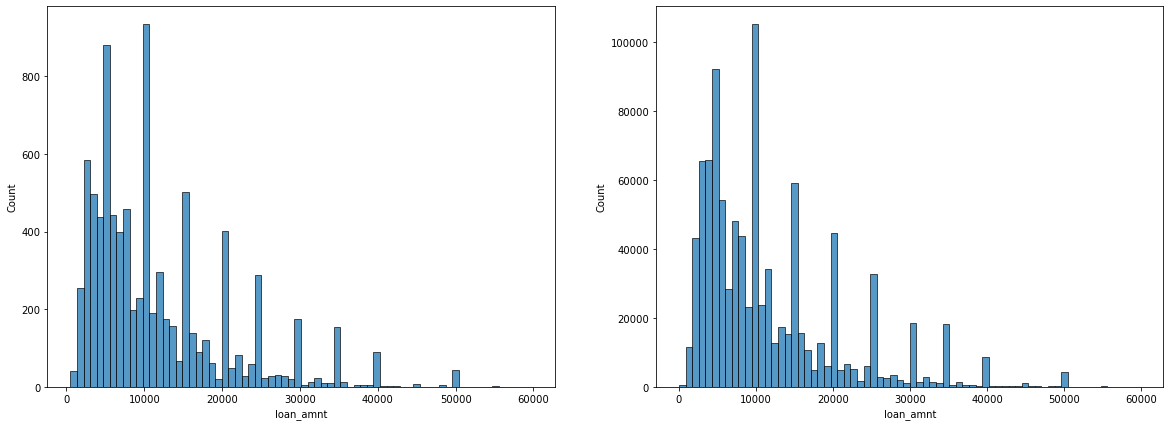

In [17]:
fig = plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(raleigh_df.loan_amnt[raleigh_df.loan_amnt<60000], bins = 70)
ax2 = plt.subplot(1, 2, 2)
sns.histplot(tu_data.loan_amnt[tu_data.loan_amnt<60000], bins = 70)
plt.show();

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

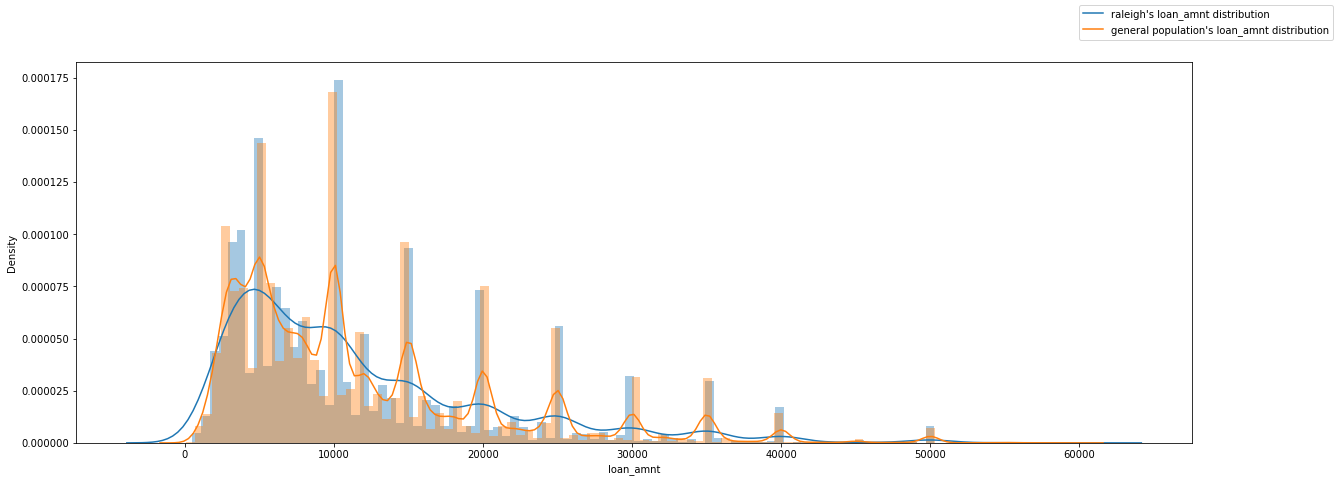

In [18]:
fig = plt.figure(figsize=(20,7))
#ax1 = plt.subplot(1, 2, 1)
sns.distplot(raleigh_df.loan_amnt[raleigh_df.loan_amnt<60000], bins = 100)
#ax2 = plt.subplot(1, 2, 2)
sns.distplot(tu_data.loan_amnt[tu_data.loan_amnt<60000], bins = 100)
fig.legend(labels=["raleigh's loan_amnt distribution","general population's loan_amnt distribution"])
plt.show();

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

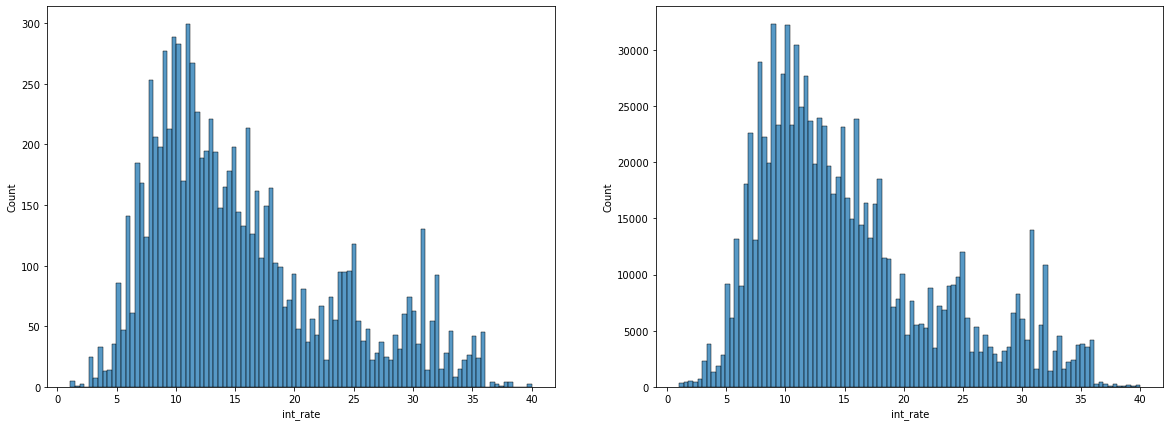

In [19]:
fig = plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(raleigh_df.int_rate, bins = 100)
ax2 = plt.subplot(1, 2, 2)
sns.histplot(tu_data.int_rate, bins = 100)
#fig.legend(labels=["raleigh's int_rate distribution","general population's int_rate distribution"])
plt.show();

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

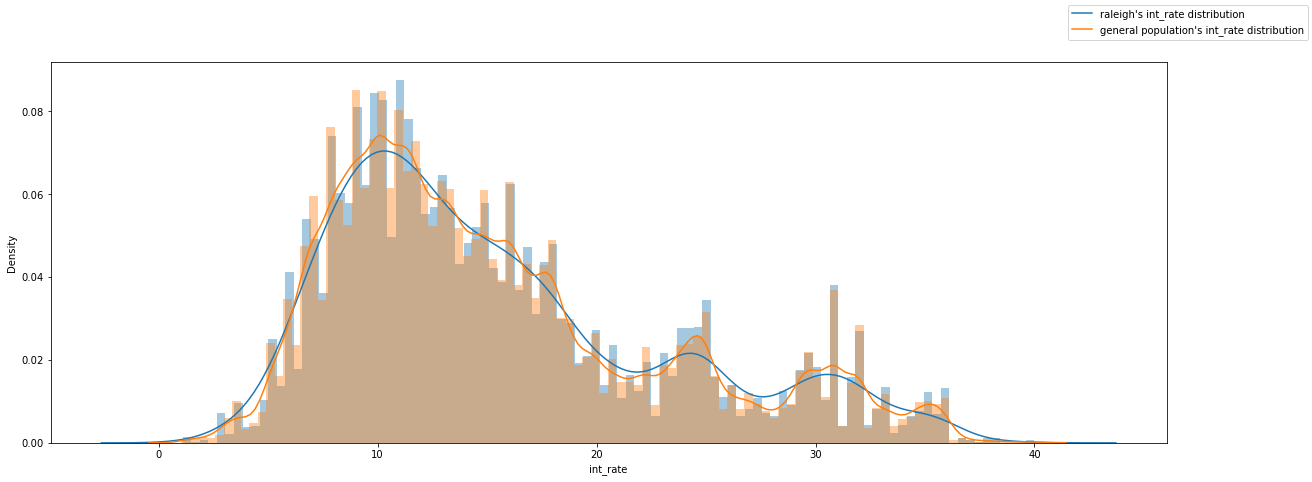

In [20]:
fig = plt.figure(figsize=(20,7))
#ax1 = plt.subplot(1, 2, 1)
sns.distplot(raleigh_df.int_rate, bins = 100)
#ax2 = plt.subplot(1, 2, 2)
sns.distplot(tu_data.int_rate, bins = 100)
fig.legend(labels=["raleigh's int_rate distribution","general population's int_rate distribution"])
plt.show();

Additionally, we want to make sure the credit scores are not visibly different in Raleigh from the general population, as this might mean that the data we obtained from the town might not be representative of the general popuation.

Create a histogram to describe the distribution of credit scores in the Raleigh sample and in the general population. Do the distributions look similar? How many bins did you use?

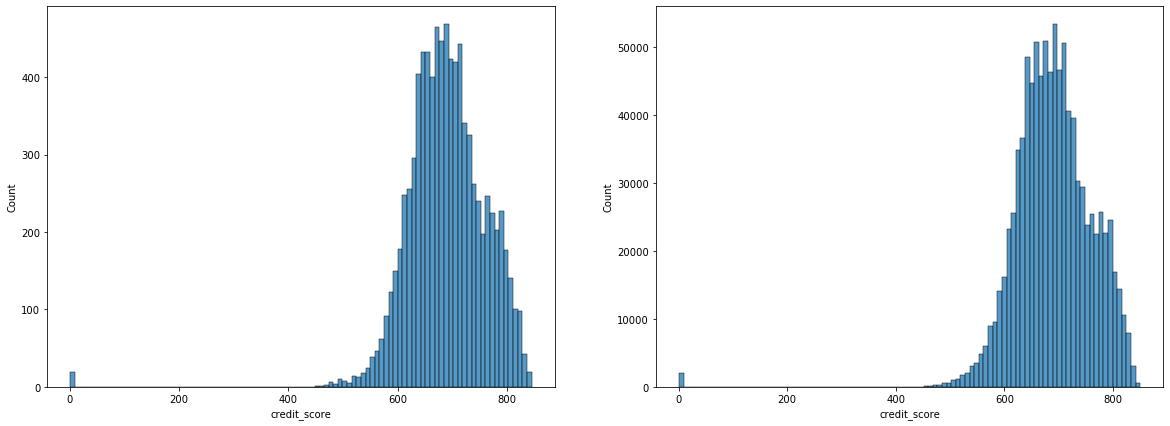

In [21]:
fig = plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
sns.histplot(raleigh_df.credit_score, bins = 100)
ax2 = plt.subplot(1, 2, 2)
sns.histplot(tu_data.credit_score, bins = 100)
#fig.legend(labels=["raleigh's int_rate distribution","general population's int_rate distribution"])
plt.show();

We see that we have observations with 0 credit score, which are outliers cause credit score range is [350,850]. lets delete these rows:

In [22]:
raleigh_df = raleigh_df.drop(raleigh_df[raleigh_df.credit_score < 350].index)
tu_data = tu_data.drop(tu_data[tu_data.credit_score < 350].index)

Describe the credit score distribution using `sns.distplot`  in the Raleigh dataframe and in TU.

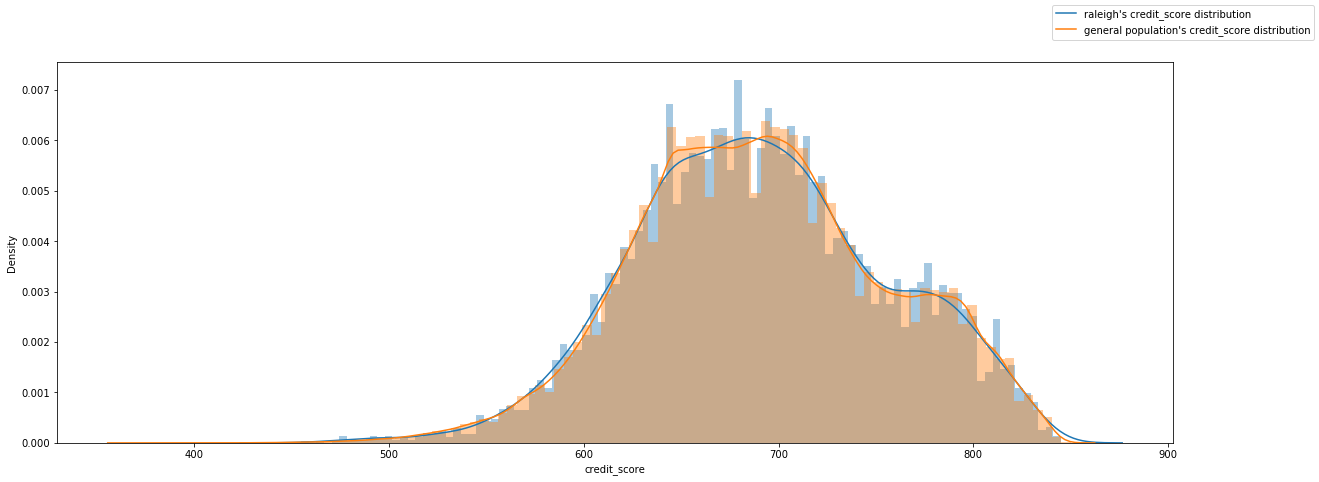

In [23]:
fig = plt.figure(figsize=(20,7))
#ax1 = plt.subplot(1, 2, 1)
sns.distplot(raleigh_df.credit_score, bins = 100)
#ax2 = plt.subplot(1, 2, 2)
sns.distplot(tu_data.credit_score, bins = 100)
fig.legend(labels=["raleigh's credit_score distribution","general population's credit_score distribution"])
plt.show();

Finally, check whether the loans in both datasets have similar distributions of term (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

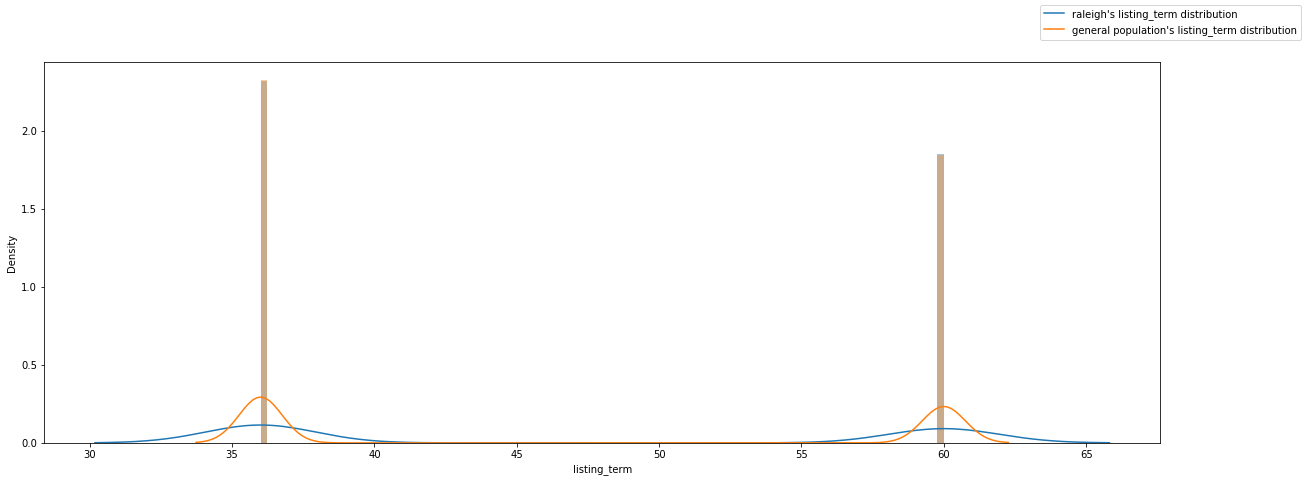

In [24]:
fig = plt.figure(figsize=(20,7))
#ax1 = plt.subplot(1, 2, 1)
sns.distplot(raleigh_df.listing_term, bins = 100)
#ax2 = plt.subplot(1, 2, 2)
sns.distplot(tu_data.listing_term, bins = 100)
fig.legend(labels=["raleigh's listing_term distribution","general population's listing_term distribution"])
plt.show();

We see that the distribution in all the parameters mentiond above is similar and the Raleig sample is not somehow distinct from the general population. <br>
For the listing term feature, we have two options, 36 month or 60 month. 

# CLT in action

One more thing before we start the test. Our goal is to check whether, for which we'll run some statistical test (you probably already know which) which checks if something belongs to a noraml distribution with some mean and some variance. But... is activation normally distributed in the Raliegh sample? 

<b> Answer: </b>Activation has two optional values, True or False, therefore in can't have continuous distribution, it's an indicator which has Bernuli distribution. 

The reason why we can assume normality is because we're checking averages of samples and we're relying on the Central Limit Theorem. We won't prove the theorem, but let's test it for a bit. 

Write a function which takes a pandas series S and a natural number n and creates a series of means of samples (with replacement) of n entries from S. Decide for yourself on the length of the output series. You can also use a different data structure if you find it more suitable as the output.

In [25]:
def CLT(s, n):
    m = int(len(s)/2)
    samples = s.sample(n*m, replace = True).to_numpy().reshape(n,m)
    samples_mean = samples.mean(axis = 0)
    return samples_mean

Optionally- also create a function which, given the same input as above, plots a histogram of the series of means, and also indicates the mean of this series.

In [26]:
def plotHist(x):
    ax = sns.kdeplot(x, shade=False, color='crimson')
    kdeline = ax.lines[0]
    mean = x.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax.vlines(mean, 0, height, color='crimson', ls=':')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    return plt

Generate plots of the series of means of activation in Raleigh and in TU for n = 1, 2, 5, 10, 100, 1000 and 1e6, and indicate their means. Does the distribution approach a normal distribution as $n\to\infty$ in your opinion?

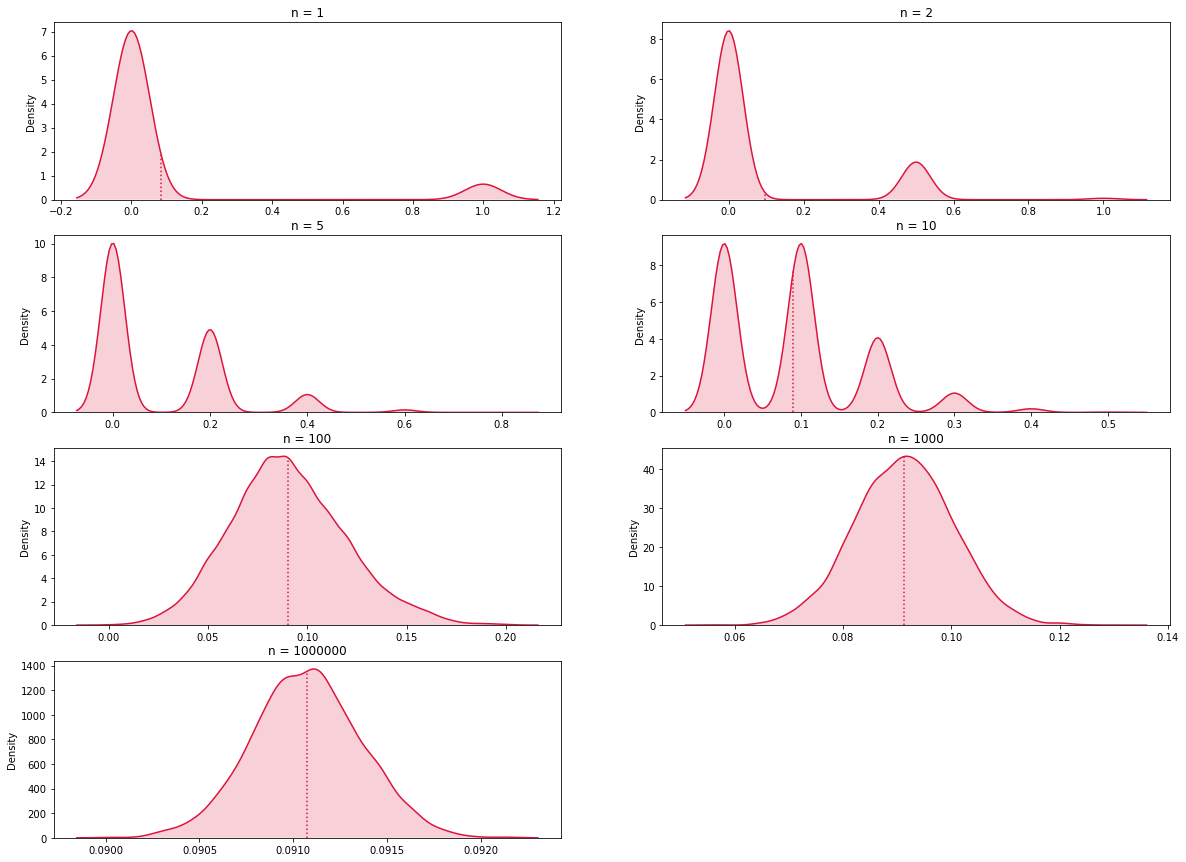

In [27]:
fig = plt.figure(figsize=(20,15))
n_s = [1, 2, 5, 10, 100, 1000, 10**6]
for i in range(1, 8):
    plt.subplot(4, 2, i)
    plotHist(CLT(raleigh_df.offer_accepted, n_s[i-1]))
    plt.title("n = "+str(n_s[i-1]))
plt.show();

Now that your fuction is ready, it's time to make it part of our infrastucture:
* Inside the `pagayapro` repo, create a branch called `feature/{your_user_name}/clt_tester/`.
* Create a file called `clt.py` inside `~/pagayapro/users/{user_name}/assignment1/` 
* Copy the two finctions you just created into the file.
* Push your file to `main`, open a PR and ask your mentor to review it. Once approved, rebase and merge.

# Statistical test 

As mentioned in the Notion doc, the activation in Raleigh before deployment was measured at 6.85%. In this section, you will run a test to check whether the activation in Raleigh is indeed different following the flyer program. 

In [29]:
!pip install statsmodels

     |████████████████████████████████| 9.9 MB 15.8 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 77.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [30]:
from statsmodels.stats.proportion import proportions_ztest

Run a statistical test to check whether the current activation rate in Raleigh is different from 6,85%:
1. What are your hypotheses?

<b>answer:</b>
$$ H_0 : p = 0.0685$$
$$ H_1 : p \neq 0.0685$$ 

2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error? What is the power of your test?

<b>answer:</b>
* Type I error is alpha, and we set the confidenvce level to be 95% so 
$$ \alpha = 0.05 = P_{H_0} (reject H_0)$$ 
* The probability of type II error is 
$$ \beta = P_{H_1} (accept H_0) $$
* The power of the test is 
$$ \Pi = 1 - \beta = P_{H_1} (reject H_0) $$

Lets calculate them, we'll use the proportion of activation in the raleigh_df to estimate the mean and variance of H_1. 

In [31]:
n = raleigh_df.shape[0]
#print(n)
p0 = 0.0685
p1 = raleigh_df.offer_accepted.mean()
var0 = (p0*(1-p0))/n
var1 = (p1*(1-p1))/n
stat, pval = proportions_ztest(count = p1*n, nobs = n, value = p0, alternative = 'two-sided')
print("p_1 = ", p1, ", var_1 = ", var1)
critical = norm.pdf(0.95, loc = p0, scale = var0)
#beta = norm.cdf(critical, loc = 0.1, scale = np.sqrt((0.1*0.9)/n))
beta = norm.cdf(stat, loc = p1, scale = np.sqrt((p1*(1-p1))/n))
print("Beta = ", beta, ", Power =", 1-beta)

p_1 =  0.09107488886355865 , var_1 =  9.435797729630581e-06
Beta =  1.0 , Power = 0.0


3. Is the sample mean significantly different from the past value of 6.85?

In [32]:
print("The p-value  is ", pval, "which is smaller than 0.05 so we reject H0")

The p-value  is  1.9949149156188576e-13 which is smaller than 0.05 so we reject H0


4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?

We can declare the program as successful in increasing the activation, because we saw that the activation precentage increased and we got really small p-value so our result are very significant. 

5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test.

We got significant results that the activation we observed is higher than our null hypothesis, which is based on the previos knowledge, but we can't say for sure it's only because of the flyers, because we didn't check the activation rate on similar data with similar features distribution with only change of the flyer program (data of clients who didn't get flyers but got the same offers as in raleigh. 

Do you see any possible problems in your methodology? What other factors can explain the change in activation, if such a change exists?

Other factors may be related to the period in which the offers were made, to the area where the offers were made (suppose there was an urban renewal project that more people needed loans to participate in the project in the specific area and were more motivated to take the loan) or other hidden factors we are unaware of. 

# A/b test

In order to isolate temporal and environmental effects on activation, we'll run an a/b test, comparing the activation rate in Raleigh to that of Lubbock, TX, another town in which Pagaya operates without a flyer program. 

The activation forms for Lubbock also appear in the `offers` subdirectory of the `ASSIGNMENT1_DATA` folder. Read all files from this folder whose name contains the substring 'lubbock', and create a dataframe of final offers called `lubbock_df`, drop unnecessary rows from it, and enrich it with TU features.

In [47]:
lubbock_forms = (glob.glob(os.path.join(ASSIGNMENT1_DATA,"offers/*lubbock*")))
print(len(lubbock_forms))
lubbock_df= pd.concat(map(pd.read_csv, lubbock_forms))
lubbock_df.offer_date = pd.to_datetime(lubbock_df.offer_date)
lubbock_df = raleigh_df.sort_values(by = ['offer_date'])
lubbock_df.drop_duplicates(subset = ['id'], keep = 'last', inplace = True, ignore_index = True)
#lubbock_df = lubbock_df.merge(tu_data, how = 'left', on = ['id', 'sequence_num'])
lubbock_df.head()

769


,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
0,d70c12d4351739a1459cb6ae041351cb12c2b87287f895...,0b3d2aad0a37fe4f74ba36aa97d85f7766abedb070ed1e...,20000.0,8.89,True,2018-01-01,812,36.0,8.89,20000.0,635.0,NC
1,f80355e60ea44ec50a1d18b9eadffd33a32bcc516a27ac...,4d02263a2e0173e14c262ce6331f9df5e66805d2650a40...,12000.0,14.92,False,2018-01-01,759,60.0,14.92,12000.0,285.0,NC
2,078f73c196351edbd24bff54cb325ef9158b2ed8969226...,607f5047e607082915ad5669fa3e42083e1597ca890ee6...,3535.0,16.98,False,2018-01-01,659,36.0,16.98,3535.0,126.0,NC
3,32ee38c813c606baab335e791fdd8a23b7a33578ccd552...,d9fc86044680663c345daca35a492b2e633de00c511044...,36000.0,3.62,False,2018-01-01,789,60.0,3.62,36000.0,657.0,NC
4,c41e2c2213656caccb20704a5637bbc19e9966d5aff082...,8938cd02ecfba20d9d166a114aba1c951c9ab994db0594...,5000.0,11.55,False,2018-01-01,674,36.0,11.55,5000.0,165.0,NC


What is the average interest rate in Lubbock? What is it among accepting borrowers?

In [34]:
print("The average interest rate offered to clients is ", lubbock_df.offered_interest_rate.mean())
print("The average interest rate among clients who accepted the offer is ", lubbock_df.loc[lubbock_df.offer_accepted == True].offered_interest_rate.mean())

The average interest rate offered to clients is  15.52708879516699
The average interest rate among clients who accepted the offer is  15.15235294117647


What is the average credit score in Lubbock? What is it among accepting borrowers?

In [35]:
print("The average credit score of the clients is ", lubbock_df.credit_score.mean())
print("The average credit score of clients who accepted the offer is ", lubbock_df.loc[lubbock_df.offer_accepted == True].credit_score.mean())

The average credit score of the clients is  691.3071925225123
The average credit score of clients who accepted the offer is  706.7634543178974


What is the rate of activation in Lubbock?

In [36]:
print("The rate of activation is ", lubbock_df.offer_accepted.mean())

The rate of activation is  0.09107488886355865


## Caution about a/b test 

Note that this is not a classical a/b test. Usually, in such a test, one creates two random subgroups from the general population and applies a manipulation to one of them in order to see if the manipulation had an effect. However, in this case, it is very complicated to isolate a random subgroup from any population and deploy the flyer program only on it.
Thus, due to production limitation, we have to make do with what we got.

In order to justify the use of an a/b test for this situation, we should at least verify that the borrower population in Lubbock and Raleigh seem as though they were randomly selected from the general population. We have actually already checked it for Raleigh above. Add TU features to the loan amount, interest rate, credit score and term comparisons and see if there any major differences between the three populations (Lubbock, Raleigh and TU).

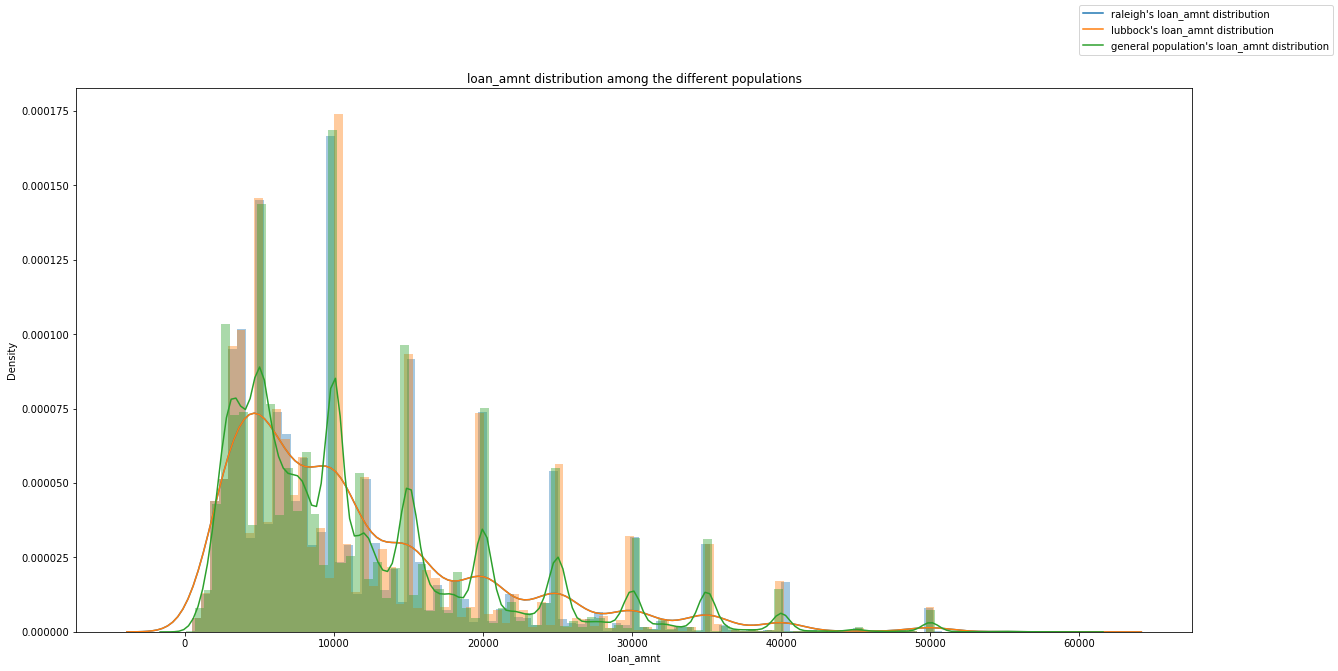

In [46]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.loan_amnt[raleigh_df.loan_amnt<60000], bins = 99)
sns.distplot(lubbock_df.loan_amnt[lubbock_df.loan_amnt<60000], bins = 100)
sns.distplot(tu_data.loan_amnt[tu_data.loan_amnt<60000], bins = 100)

fig.legend(labels=["raleigh's loan_amnt distribution","lubbock's loan_amnt distribution", "general population's loan_amnt distribution"])
plt.title("loan_amnt distribution among the different populations")

plt.show();

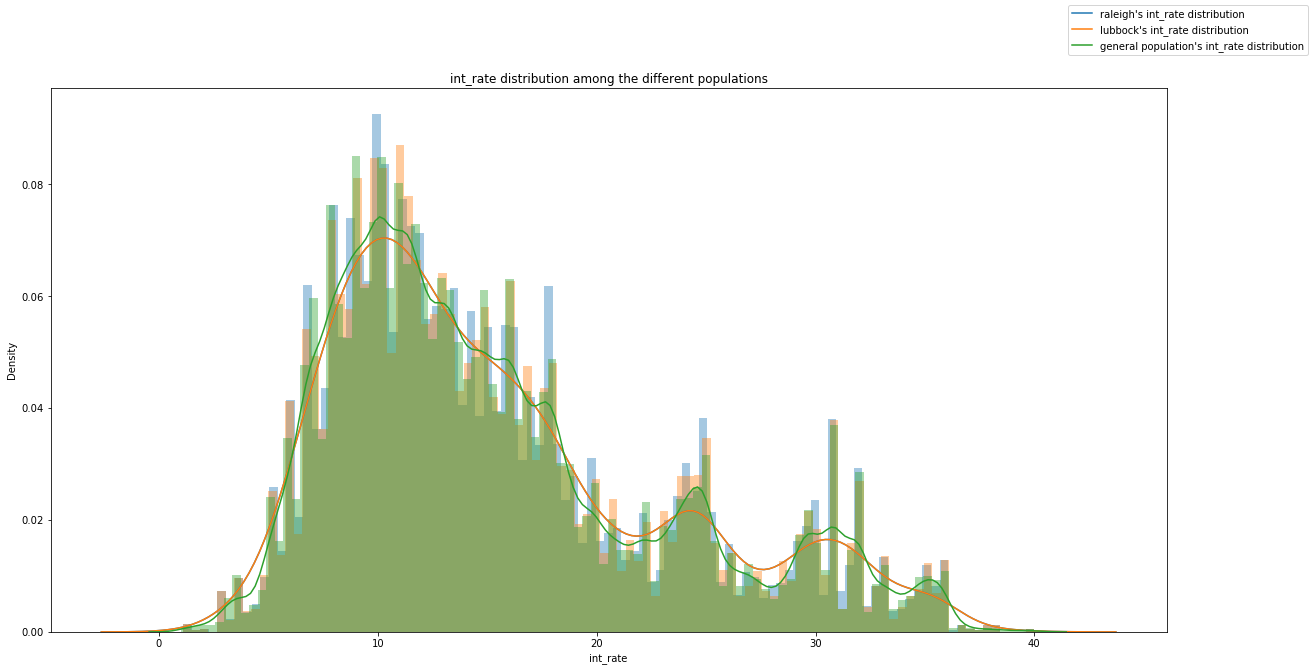

In [49]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.int_rate, bins = 99)
sns.distplot(lubbock_df.int_rate, bins = 100)
sns.distplot(tu_data.int_rate, bins = 100)

fig.legend(labels=["raleigh's int_rate distribution","lubbock's int_rate distribution","general population's int_rate distribution"])
plt.title("int_rate distribution among the different populations")
plt.show();

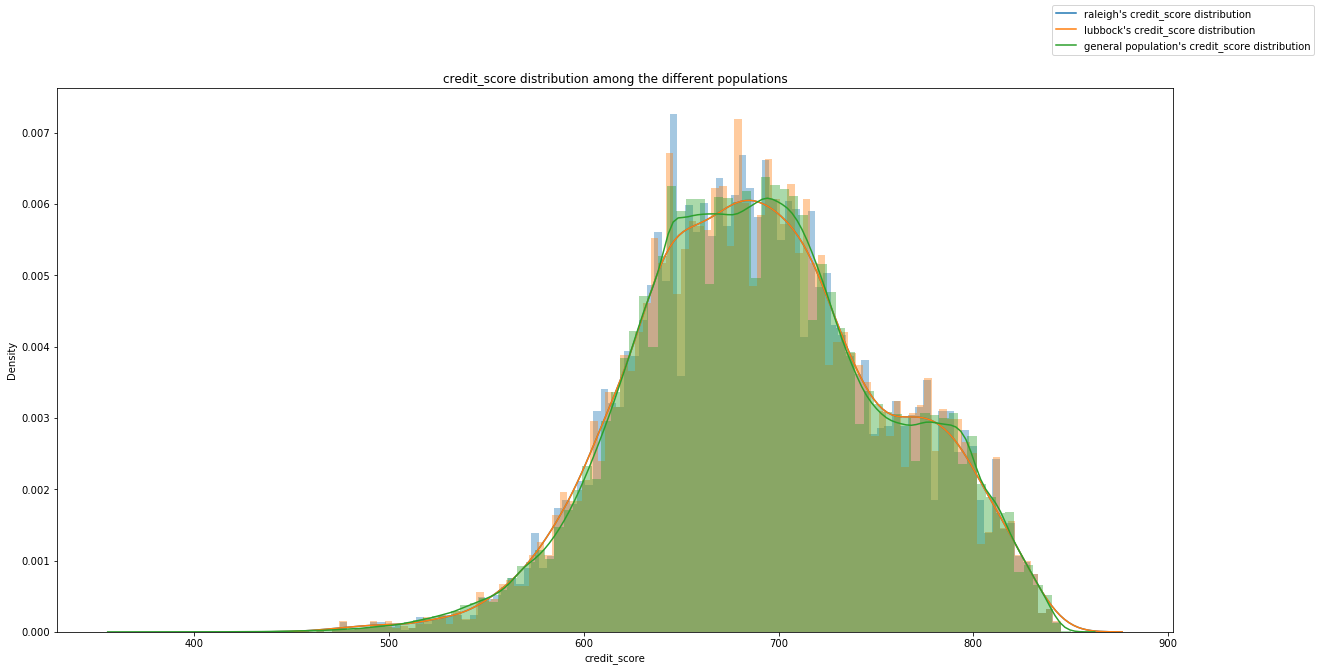

In [50]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.credit_score, bins = 99)
sns.distplot(lubbock_df.credit_score, bins = 100)
sns.distplot(tu_data.credit_score, bins = 100)

fig.legend(labels=["raleigh's credit_score distribution","lubbock's credit_score distribution","general population's credit_score distribution"])
plt.title("credit_score distribution among the different populations")
plt.show();

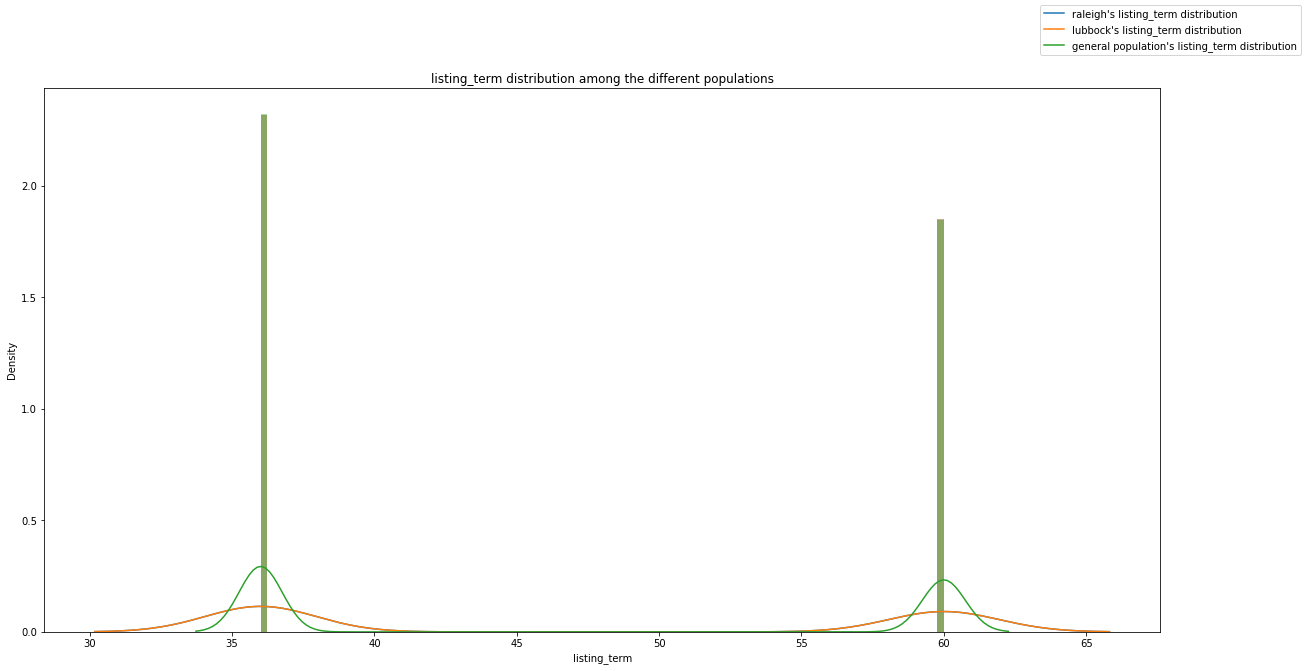

In [60]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_df.listing_term, bins = 100)
sns.distplot(lubbock_df.listing_term, bins = 100)
sns.distplot(tu_data.listing_term, bins = 100)

fig.legend(labels=["raleigh's listing_term distribution","lubbock's listing_term distribution","general population's listing_term distribution"])
plt.title("listing_term distribution among the different populations")
plt.show();

Looks like there's no main difference between the populations.

## Performing the test

Use the function you created in the file `clt.py` to plot the series of means of activation in Raleigh and Lubbock for samples of size n= 1, 10, 1000 and 1e6, and compare the means of the two histograms. To they seem to converge to the same value?

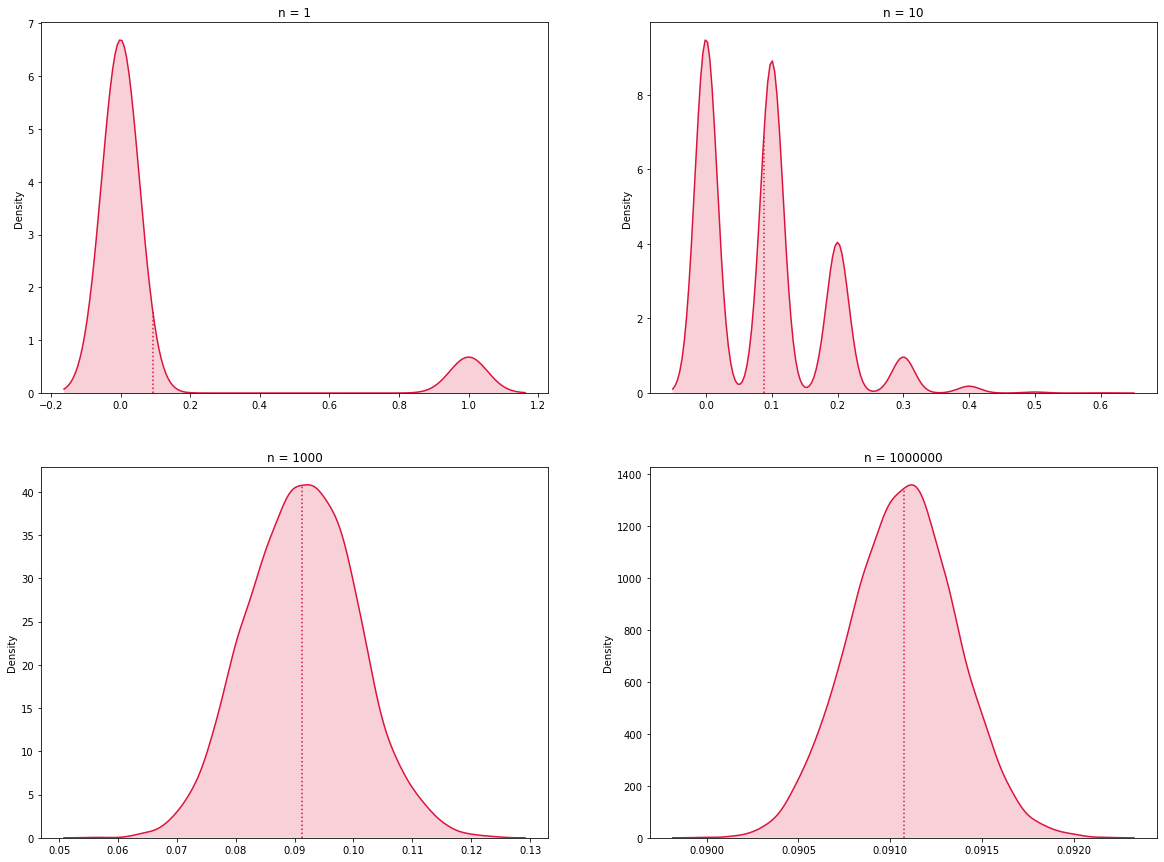

In [64]:
fig = plt.figure(figsize=(20,15))
n_s = [1, 10, 1000, 10**6]
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plotHist(CLT(raleigh_df.offer_accepted, n_s[i-1]))
    plt.title("n = "+str(n_s[i-1]))
plt.show();

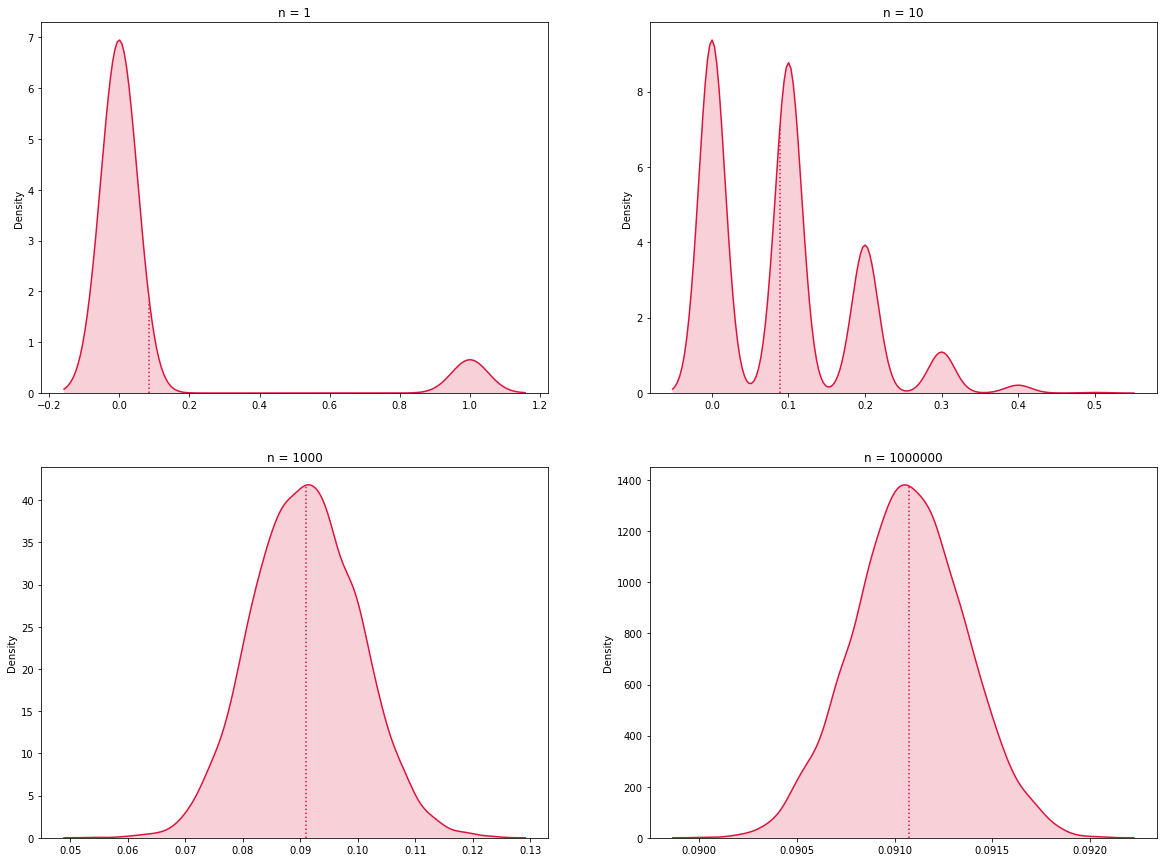

In [65]:
fig = plt.figure(figsize=(20,15))
n_s = [1, 10, 1000, 10**6]
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plotHist(CLT(lubbock_df.offer_accepted, n_s[i-1]))
    plt.title("n = "+str(n_s[i-1]))
plt.show();

Apply a statistical test to see whether the activation rate in Raleigh, NC is significantly larger than Lubbock, TX. Clearly state and validate your test's assumption. 

(Use the `proportions_ztestz` function from `statsmodels.stats.proportion` to perform a comparison between the activation probability in Lubbock and in Raleigh). 



1. What are your hypotheses?

<b>answer:</b>
$$ H_0 : p_R = p_L$$
$$ H_1 : p_R \neq p_L$$ 

2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error?

<b>answer:</b>
* Type I error is alpha, and we set the confidenvce level to be 95% so 
$$ \alpha = 0.05 = P_{H_0} (reject H_0)$$ 
* The probability of type II error is 
$$ \beta = P_{H_1} (accept H_0) $$
* The power of the test is 
$$ \Pi = 1 - \beta = P_{H_1} (reject H_0) $$

Lets calculate them:

In [72]:
p_R = raleigh_df.offer_accepted.mean()
p_L = lubbock_df.offer_accepted.mean()
counts = [raleigh_df.offer_accepted.sum(), lubbock_df.offer_accepted.sum()]
nobs = [raleigh_df.offer_accepted.count(), lubbock_df.offer_accepted.count()]
stat, pval = proportions_ztest(count = counts, nobs = nobs, alternative = 'two-sided')

3. Are the two samples significantly different? 

In [70]:
print("The p-value  is", pval, ", so we don't reject H0")
#check

The p-value  is 1.0 , so we don't reject H0


4. Interpret your results. Can you declare the program as successful in increasing activation? What is the probability of wrongfully declaring it successful?

# Testing for activation in sub-populations

Now that you applied the a/b test to the Lubbock and Raleigh datasets, it is now required that you make a similar comparison on different subsets of the data within various credit score and loan amount bins. To do so, let us first decide on how to segment our data.

You are asked to divide your data into 10 bins according to loan amount, and then divide each of those bins into 10 bins according to loan amount. The most staightforward way of doing this is by using the `pd.qcut` function; first dividing the data into 10 quantiles of credit score and then dividing each of these quantiles into 10 according to loan amount.

Divide your datasets as above and add two columns to your data which indicate the (credit_score, loan_amnt) of the bin.

Run an a/b test on each of the bins in your data and create a $10\times 10$ table containing the $p$ value of each test.

Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

What is the probability of falsely rejecting the null hypothesis in each cell? What is the probability of falsely rejecting the null hypothesis in at least one of the cells (i.e. what is the **family wise error rate**)?

In other words, given that we made $m$ experiments, with confidence level $\alpha$, what is the probabilty $\mathbb{P}\left(\bigcup_i X_i \le q_{\alpha}\right)$? 

_Note_: you may assume that sampling from different bins are independent.

## Bonferroni correction 

One way of assuring that your FWER remains below $\alpha=0.05$ is to apply a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">**Bonferroni correction**</a>. This means that we set the signficance level of each individual test to $\alpha/m$, where $m=100$ is the number of tests (see, e.g., Wikipedia for an explanation). 

Use a Bonferroni correction on your segmented a/b test and output a $10\times10$ table of boolean values, indicating which test gave a significant result under this correction.

How many of your tests came out significant under this correction?

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

## BH correction 

The Bonferroni correction is often criticized for being too restrictive, as you probably noticed in the last subsection. A more commonly used method for correcting $\alpha$ values is the Benjamini-Hochberg method. You can <a href="https://www.youtube.com/watch?v=K8LQSvtjcEo">check out the quest</a> for a nice explanation about it.

Start by arranging the $p$-values of your original test as a series and listing them in ascending order. You can use the `pd.DataFrame.stack` and `pd.Series.sort_values` methods.

Plot your sorted $p$-values

For each entry of the new series, compute the value compute the value $\frac{i}{m}\cdot\alpha$, where $i$ is the ordinal place of the entry (i.e. 1,2,...len(series)), $m=100$ and $\alpha=0.05$ as above. Add a plot of these values to your $p$-values plot.

Find the largest index $i$ for which the $p$-value in the $i$-th place in the series is smaller than $\frac{i}{m}\cdot\alpha$. That is- the last index in the plot you just created where the $p$-values line lies below the _adjusted_-$\alpha$ line.

Reject the null hypothesis for all test before and including this index, and accept it for all others. Reformat your table into a $10\times 10$ dataframe; for which bins did we get a significant result in the corrected test?

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

### Validating your results

You can validate your results (for both corrections) using the <a href= "https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html">`statsmodels.stats.multitest.multipletests`</a> package.